In [5]:
%matplotlib inline

import sys
import os
import shutil
import time
import traceback
from pathlib import Path
import h5py
import json
import pickle
from types import SimpleNamespace
from importlib import reload

from scipy import signal, stats, spatial, ndimage
from scipy.interpolate import interp1d
from sklearn import linear_model as lm
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

## added TreeMazeanalyses folder using the following command
## conda develop /home/alexgonzalez/Documents/TreeMazeAnalyses2
import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Utils.filter_functions as filter_funcs 
import TreeMazeAnalyses2.Pre_Processing.pre_process_functions as pp_funcs

from TreeMazeAnalyses2.Analyses.subject_info import SubjectInfo, SubjectSessionInfo
from TreeMazeAnalyses2.Analyses import spatial_functions as spatial_funcs
import TreeMazeAnalyses2.Analyses.open_field_functions as of_funcs

from ipywidgets import interact, fixed
import ipywidgets as widgets

In [2]:
subject_id = 'Li'
session = 'Li_OF_060718'
#subject_info = SubjectInfo(subject_id, overwrite=True)
subject_info = SubjectInfo(subject_id)
session_info = SubjectSessionInfo(subject_id,session)
track_params = SimpleNamespace(**session_info.task_params)

n_units = session_info.n_units
print(session_info)
session_info.print_task_params()



Session Information for subject Li, session Li_OF_060718
Number of curated units: 37
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> time. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> spike_maps. Executed = True
  -> maps. Executed = False
  -> scores. Executed = True
  -> encoding_models. Executed = True

To run all analyses use run_analyses().


Task/track and analysis parameters. 

  -> time_step: 0.02
  -> x_pix_lims: [100, 650]
  -> y_pix_lims: [100, 500]
  -> x_pix_bias: -380
  -> y_pix_bias: -280
  -> vt_rate: 0.016666666666666666
  -> xy_pix_rot_rad: 1.6507963267948966
  -> x_pix_mm: 3.7790697674418605
  -> y_pix_mm: 3.265765765765766
  -> x_mm_bias: 20
  -> y_mm_bias: 650
  -> x_mm_lims: [-630, 630]
  -> y_mm_lims: [-60, 1350]
  -> x_cm_lims: [-63, 63]
  -> y_cm_lims: [-6, 135]
  -> mm_bin: 30
  -> cm_bin: 3
  -> max_speed_thr: 80
  -> min_speed_

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load data

In [3]:
spks,_,_ = session_info.get_spikes()
binned_spks = session_info.get_binned_spikes()
fr = session_info.get_fr()
t_rs = session_info.get_time()
of_dat = session_info.get_track_data() 
of_dat = SimpleNamespace(**of_dat)
spike_maps = session_info.get_spike_maps()
fr_maps = session_info.get_fr_maps(overwrite=True)

Open Field Firing Rate Maps not Found or Overwrite= True, creating them.


In [6]:
def plot_map(map_):
    f, ax = plt.subplots(figsize=(6,6))
    ax = sns.heatmap(map_, ax=ax)
    ax.invert_yaxis()
    ax.axis('equal')
    ax.axis('off')
    return f,ax
    
def plot_unit_map(unit, maps_):
    return plot_map(maps_[unit])
    

_=interact(plot_unit_map, unit=widgets.IntSlider(min=0, max=n_units-1, step=1, value=0), maps_=fixed(fr_maps))


interactive(children=(IntSlider(value=0, description='unit', max=36), Output()), _dom_classes=('widget-interac…

# Development of Solstad Border Score
The border score is defined as:

$$ b = \frac{c_m - d_m}{c_m + d_m} $$

where $c_m$ corresponds to the maximum border coverage of a given field, and $d_m$ is the linearly distance weighted firing rate to the center.

Text(0.5, 1.0, 'Thresholded map')

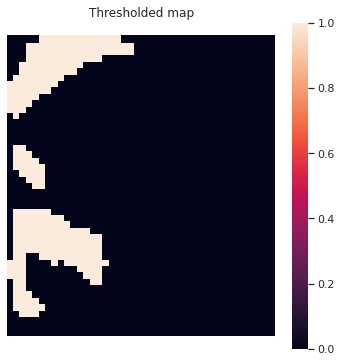

In [5]:
unit = 10
fr_thr = 0.25

fr_map = fr_maps[unit]
max_fr = fr_map.max()
thr_map = fr_map>=fr_thr*max_fr
f,ax=plot_map(thr_map)
ax.set_title('Thresholded map')

#### basic image processing

Text(0.5, 1.0, 'Thresholded map')

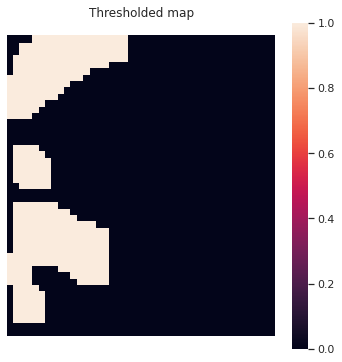

In [6]:
thr_map = fr_map>=fr_thr*max_fr
border_mask = np.ones_like(fr_map, dtype=bool)
border_mask[[0,-1],:] = False
border_mask[:,[0,-1]] = False

# eliminates small
thr_map2=ndimage.binary_opening(thr_map,structure=np.ones((3,3)))
thr_map2=ndimage.binary_closing(thr_map2,structure=np.ones((3,3)), mask=border_mask)
thr_map3=ndimage.binary_dilation(thr_map2,structure=np.ones((3,3)))

_, ax= plot_map(thr_map3)
ax.set_title('Thresholded map')

Text(0.5, 1.0, ' Field IDs ')

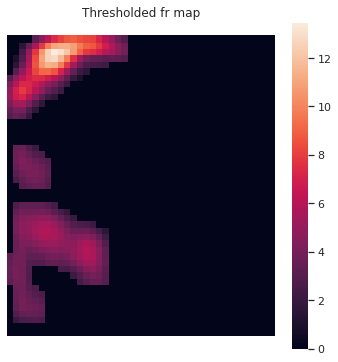

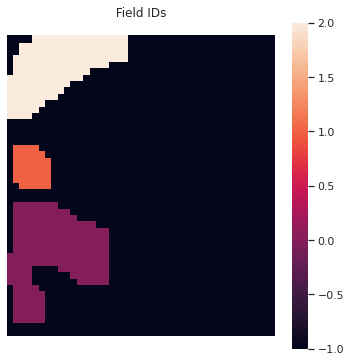

In [7]:
# get field ids
fields_map, n_fields = ndimage.label(thr_map3, structure=np.ones((3,3)))

#check for small fields
field_sizes_cm2 = np.zeros(n_fields)
bin_cm2 =track_params.cm_bin**2
for f in range(n_fields):
    field_sizes_cm2[f] = (np.sum(fields_map==f)*bin_cm2)
    
min_field_size_cm2 = 200
if np.any(field_sizes_cm2<min_field_size_cm2):
    small_fields = np.where(field_sizes_cm2<min_field_size_cm2)[0]
    for f in small_fields:
        thr_map3[fields_map==f] = 0
    fields_map, n_fields = ndimage.label(thr_map3, structure=np.ones((3,3)))

fields_map-=1 # zero-center
f, ax = plot_map(fr_map*(fields_map>=0))
ax.set_title('Thresholded fr map')

f,ax = plot_map(fields_map)
ax.set_title(' Field IDs ')

### get border mask

126

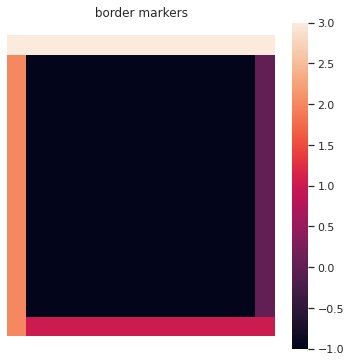

In [27]:
border_width = track_params.border_width_bins  
map_height, map_width = fr_map.shape # in bins
border_wide_mask = np.ones_like(fr_map, dtype=int)*-1
border_wide_mask[:, (map_width):(map_width-border_width-1):-1] = 0 # right / East

border_wide_mask[0:border_width,:] = 1 # top / North
border_wide_mask[:, 0:border_width] = 2 # left / West
border_wide_mask[map_height:(map_height-border_width-1):-1,:] = 3 # bottom / Sout

f,ax = plot_map(border_wide_mask)
ax.set_title(' border markers ')
np.sum(border_wide_mask==3)

### get linear distance to closest wall

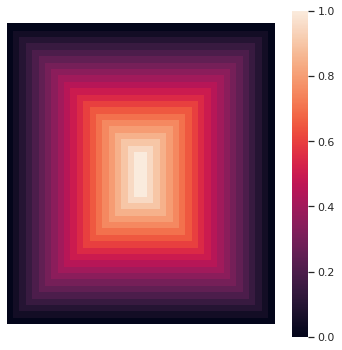

In [28]:
distance_mat = spatial_funcs.get_center_border_distance_mat(map_height,map_width)
f,ax = plot_map(distance_mat)

### get max border coverage

In [29]:
wall_coverage = np.zeros((n_fields, 4))
wall_labels_mask = spatial_funcs.get_wall_masks(map_height, map_width, border_width)

for field in range(n_fields):
    for wall in range(4):
        wall_coverage[field, wall] = \
        np.sum((fields_map == field) * (wall_labels_mask[wall] == wall)) \
        / np.sum(wall_labels_mask[wall] == wall)
        
c_m = np.max(wall_coverage)

In [30]:
np.sum(wall_labels_mask==3)

126

In [31]:
print(pd.DataFrame(wall_coverage, columns=['E', 'N', 'W', 'S']))
print(f'\n c_m = {c_m:0.3f}')

     E         N         W         S
0  0.0  0.000000  0.304965  0.039683
1  0.0  0.000000  0.092199  0.000000
2  0.0  0.380952  0.205674  0.000000

 c_m = 0.381


### get weighted firing rate

In [94]:
field_fr_map = fr_map * (fields_map >= 0)
d_m = np.sum(field_fr_map * distance_mat) / np.sum(field_fr_map)
print(f' d_m = {d_m:0.3f}')

 d_m = 0.207


### border score

In [95]:
b = (c_m-d_m)/(c_m+d_m)
print(f' b = {b:0.3f}')

 b = 0.296


In [97]:
out = spatial_funcs.get_border_encoding_model(of_dat.x, of_dat.y, fr, fr_maps, track_params.x_bin_edges_, track_params.y_bin_edges_)

NameError: name 'out' is not defined

In [48]:
border_model_coeff = pd.DataFrame(out[1], columns=['bias', 'East', 'North', 'Center'])
border_model_coeff.loc[unit]

bias      1.528328
East     -0.363710
North     0.469864
Center   -0.735573
Name: 11, dtype: float64

### test border score method

In [32]:

def test_border_score():

    height=50
    width=40
    
    n_tests = np.zeros(8)
    dummy_mat = np.zeros((8, height, width))
    
    #print('Border Score for an east single wall') 
    dummy_mat[0][:,-1]=1 # 
    
    #print('Border Score for a north single wall')
    dummy_mat[1][0,:]=1 # 
    
    #print('Border Score for a west single wall')
    dummy_mat[2][:,0]=1 # 
    
    #print('Border Score for a south single wall')
    dummy_mat[3][-1,:]=1 # 
    
    #print('Border Score for center region')
    dummy_mat[4][(height//2-2):(height//2+2),(width//2-2):(width//2+2)]=1
    
    #print('Border Score for thick wall')
    dummy_mat[5][0:5,:]=1
    
    #print('Border Score for full coverage')
    dummy_mat[6] = np.ones((height, width))
    
    #print('Border Score for full coverage')
    dummy_mat[7][:,-1]=1
    dummy_mat[7][-1,:]=1
    dummy_mat[7][:,0]=1
    dummy_mat[7][0,:]=1
    
    b,_=spatial_funcs.get_border_score_solstad(dummy_mat)
    
    return b, dummy_mat


b, dummy_mat = test_border_score()

def plot_test_map(test_num):
    print(f'Border Score = {b[test_num]:0.3f}')

    f, ax = plt.subplots(figsize=(6,6))
    ax = sns.heatmap(dummy_mat[test_num], ax=ax, cmap='Greys' )
    ax.invert_yaxis()
    ax.axis('equal')
    return f,ax
    
_=interact(plot_test_map, test_num=widgets.IntSlider(min=0, max=len(b)-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='test_num', max=7), Output()), _dom_classes=('widget-inte…

# develop glm version

Text(0.5, 1.0, 'Distance to Center from a Wall')

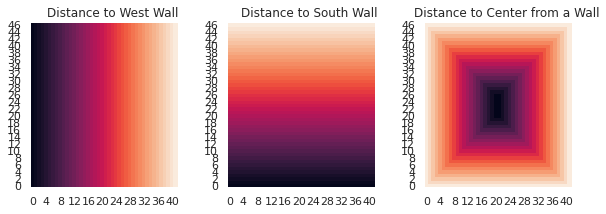

In [34]:
# in this implementation west dist represents the distance to the west wall,
# however, this is counter intuitive as a positive relationship would mean east coding

height, width = fr_maps.shape[1:]
spatial_funcs = reload(spatial_funcs)
west_dist = np.tile(np.arange(width),height).reshape(height,width)
west_dist = west_dist/ np.max(west_dist)

south_dist = np.repeat(np.arange(height),width).reshape(height,width)
south_dist = south_dist/ np.max(south_dist)

wall_center_dist = 1-spatial_funcs.get_center_border_distance_mat(height,width)

f,ax=plt.subplots(1,3, figsize=(10,6))
sns.heatmap(west_dist,ax=ax[0],cbar=False)
ax[0].invert_yaxis()
ax[0].axis('square')
ax[0].set_title('Distance to West Wall')

sns.heatmap(south_dist,ax=ax[1],cbar=False)
ax[1].invert_yaxis()
ax[1].axis('square')
ax[1].set_title('Distance to South Wall')

sns.heatmap(wall_center_dist,ax=ax[2],cbar=False)
ax[2].invert_yaxis()
ax[2].axis('square')
ax[2].set_title('Distance to Center from a Wall')

another implementation is not to call it distance, but proximity. and not use a linear scale. we use a sigmoid function to estimate the value near a wall. The critical implementation detail is the slope of the sigmoid such that at some distance 'wall_width' the values saturate. We do this with a combination of analytical and numerical approaches.

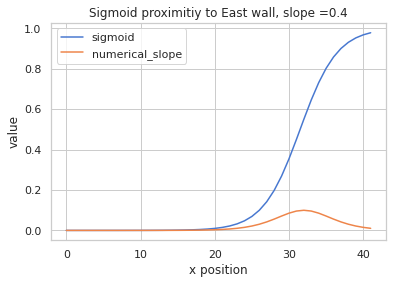

In [35]:
def sigmoid(x, center, slope):
    return 1./(1+np.exp(-slope*(x-center)))

x=np.arange(width)
slope = 0.4
z = sigmoid(x,width/4*3,slope)
plt.plot(x,z, label='sigmoid')
plt.plot(np.append(0,np.diff(z)), label = 'numerical_slope')
plt.xlabel('x position')
plt.ylabel('value')
plt.title(f'Sigmoid proximitiy to East wall, slope ={slope}')
plt.legend()

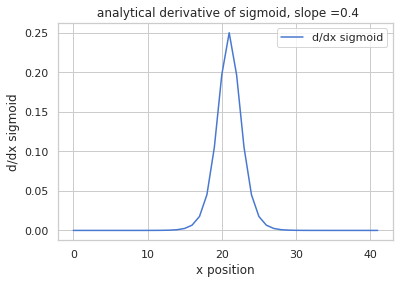

In [36]:
def d_sigmoid(x, center, slope):
    u = np.exp(-slope*(x-center))
    return slope*u/(1+u)**2

plt.plot(x,d_sigmoid(x,width/2,1),label='d/dx sigmoid')
plt.xlabel('x position')
plt.ylabel('d/dx sigmoid')
plt.title(f' analytical derivative of sigmoid, slope ={slope}')
plt.legend()

Text(0.5, 1.0, 'optimal slope vs wall width')

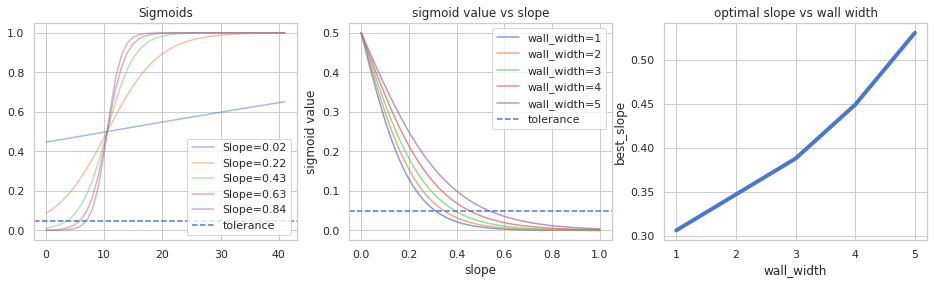

In [37]:
# find slopes for different wall widths, using sigmoid
max_width = 6
center = width/4
tolerance = 0.05 # acccepted value of sigmoid at the wall value

wall_widths = np.arange(1,max_width)
slopes = np.linspace(0,1,50)
best_slopes = np.zeros(max_width-1)

f, ax = plt.subplots(1,3, figsize=(16,4))
x = np.arange(width)
for jj, sl in enumerate(slopes[1::10]):
    z = sigmoid(x,center,sl)
    ax[0].plot(z, alpha=0.5, label=f'Slope={sl:0.2f}')

ax[0].set_title('Sigmoids')
ax[0].axhline(tolerance,linestyle='--', label = 'tolerance')
ax[0].legend()


for ii, wall_width in enumerate(wall_widths):
    z = sigmoid(wall_width,center,slopes)
    #best_slopes[ii] = slopes[np.argmin(np.abs(z-tolerance))]
    best_slopes[ii] = slopes[np.argmin((z-tolerance)**2)]
    ax[1].plot(slopes,z, alpha=0.7, label=f'wall_width={wall_width}')
ax[1].axhline(tolerance,linestyle='--', label = 'tolerance')
ax[1].legend()
ax[1].set_xlabel('slope')
ax[1].set_ylabel('sigmoid value')
ax[1].set_title('sigmoid value vs slope')

ax[2].plot(wall_widths, best_slopes,linewidth=4)
ax[2].set_xlabel('wall_width')
ax[2].set_ylabel('best_slope')
ax[2].set_title('optimal slope vs wall width')

In [38]:
def find_optimum_sigmoid_slope(wall_width, center, goal=0.05):
    slopes = np.linspace(0,2,200)
    z = sigmoid(wall_width,center,slopes)
    return slopes[np.argmin((z-goal)**2)]
    
wall_width = 3
slope_x = find_optimum_sigmoid_slope(wall_width, width//2) 
slope_y = find_optimum_sigmoid_slope(wall_width, height//2) 
print(slope_x, slope_y)


0.16080402010050251 0.15075376884422112


use gaussian to get proximity to center

(0.0, 42.0, 0.0, 47.0)

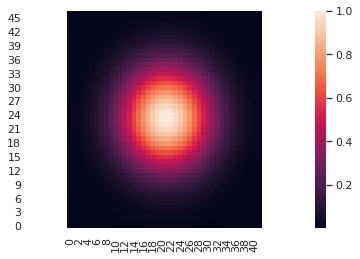

In [39]:
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

x, y = np.meshgrid(np.arange(width),np.arange(height)) # get 2D variables instead of 1D
center_prox = gaus2d(y=y, x=x, my=height/2, mx=width/2, sx=width/6, sy=height/6)
center_prox = center_prox/np.max(center_prox)
ax=sns.heatmap(center_prox)
ax.invert_yaxis()
ax.axis('equal')


Text(0.5, 1.0, 'Proximity to Center')

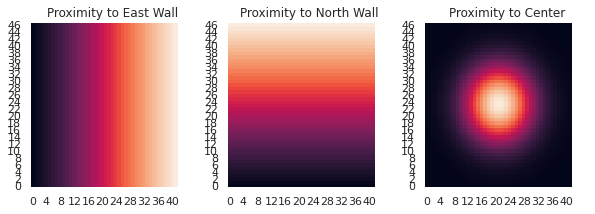

In [41]:
wall_width = 3
sigmoid_slope_w = find_optimum_sigmoid_slope(wall_width, width, goal=0.1) 
sigmoid_slope_h = find_optimum_sigmoid_slope(wall_width, height, goal=0.1) 
center_w = width/2
center_h = height/2

east_prox = np.tile(sigmoid(np.arange(width), width/2, sigmoid_slope_w),height).reshape(height,width)
north_prox = np.repeat(sigmoid(np.arange(height), height/2, sigmoid_slope_h),width).reshape(height,width)

f,ax=plt.subplots(1,3, figsize=(10,6))
sns.heatmap(east_prox,ax=ax[0],cbar=False)
ax[0].invert_yaxis()
ax[0].axis('square')
ax[0].set_title('Proximity to East Wall')

sns.heatmap(north_prox,ax=ax[1],cbar=False)
ax[1].invert_yaxis()
ax[1].axis('square')
ax[1].set_title('Proximity to North Wall')

sns.heatmap(center_prox,ax=ax[2],cbar=False)
ax[2].invert_yaxis()
ax[2].axis('square')
ax[2].set_title('Proximity to Center')

for each x,y position get a 3 feature vector reflecting the distance to the north wall, west wall and center

In [42]:
_,x_bin_idx,=rs.get_discrete_data_mat(of_dat.x, bin_edges=track_params.x_bin_edges_)
_,y_bin_idx,=rs.get_discrete_data_mat(of_dat.y, bin_edges=track_params.y_bin_edges_)

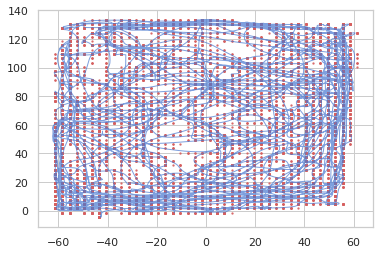

In [43]:
plt.plot(of_dat.x, of_dat.y, alpha=0.7, linewidth=1)
plt.scatter(track_params.x_bin_centers_[x_bin_idx],track_params.y_bin_centers_[y_bin_idx], s=2, alpha=0.75, color='r')

In [44]:
wall_width = 3
sigmoid_slope_w = find_optimum_sigmoid_slope(wall_width, width, goal=0.1) 
sigmoid_slope_h = find_optimum_sigmoid_slope(wall_width, height, goal=0.1) 
center_w = width/2
center_h = height/2

east_prox = np.tile(sigmoid(np.arange(width), width/2, sigmoid_slope_w),height).reshape(height,width)
north_prox = np.repeat(sigmoid(np.arange(height), height/2, sigmoid_slope_h),width).reshape(height,width)

_,x_bin_idx,=rs.get_discrete_data_mat(of_dat.x, bin_edges=track_params.x_bin_edges_)
_,y_bin_idx,=rs.get_discrete_data_mat(of_dat.y, bin_edges=track_params.y_bin_edges_)

wd = west_dist[y_bin_idx,x_bin_idx]
sd = south_dist[y_bin_idx,x_bin_idx]
cd = wall_center_dist[y_bin_idx,x_bin_idx]

X_lin = np.column_stack((np.ones_like(wd), wd, sd, cd))
model_lin = lm.LinearRegression(fit_intercept=False).fit(X_lin, fr.T)
fr_hat_lin = model_lin.predict(X_lin).T

ep = east_prox[y_bin_idx,x_bin_idx]
north_p = north_prox[y_bin_idx, x_bin_idx]
cp = center_prox[y_bin_idx, x_bin_idx]

X_sm = np.column_stack((np.ones_like(ep), ep, north_p, cp))
model_sm = lm.LinearRegression(fit_intercept=False).fit(X_sm, fr.T)
fr_hat_sm = model_sm.predict(X_sm).T
# model_coef[unit] = model.coef_

In [45]:
ar2_lin = rs.get_ar2(fr, fr_hat_lin, 3)
ar2_sm = rs.get_ar2(fr, fr_hat_sm, 3)

rmse_lin = rs.get_rmse(fr, fr_hat_lin)
rmse_sm = rs.get_rmse(fr, fr_hat_sm)

nrmse_lin = rs.get_nrmse(fr, fr_hat_lin)
nrmse_sm = rs.get_nrmse(fr, fr_hat_sm)

NameError: name 'out' is not defined

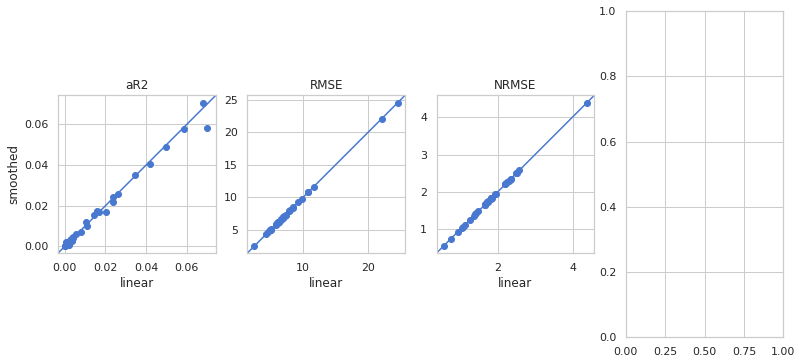

In [46]:
f,ax=plt.subplots(1,4, figsize=(13,6))
ax[0].scatter(ar2_lin,ar2_sm)
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes)
ax[0].axis('square')
ax[0].set_xlabel('linear')
ax[0].set_ylabel('smoothed')
ax[0].set_title('aR2')

ax[1].scatter(rmse_lin,rmse_sm)
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes)
ax[1].axis('square')
ax[1].set_xlabel('linear')
ax[1].set_title('RMSE')

ax[2].scatter(nrmse_lin,nrmse_sm)
ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes)
ax[2].axis('square')
ax[2].set_xlabel('linear')
ax[2].set_title('NRMSE')

ax[3].scatter(out[0]['solstad_score'],ar2_sm)
#ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes)
ax[3].axis('square')
ax[3].set_xlabel('border_score')
ax[3].set_title('Border Score vs aR2')

### Encoding model with independent wall model

In [50]:
wall_width = 3
goal = 0.15
sigmoid_slope_w = find_optimum_sigmoid_slope(wall_width, width/4, goal=goal) 
sigmoid_slope_h = find_optimum_sigmoid_slope(wall_width, height/4, goal=goal) 

center_w = width/2
center_h = height/2

west_prox = np.tile(1-sigmoid(np.arange(width), width/4, sigmoid_slope_w),height).reshape(height,width)
east_prox = np.fliplr(west_prox)
south_prox = np.repeat(1-sigmoid(np.arange(height), height/4, sigmoid_slope_h),width).reshape(height,width)
north_prox = np.flipud(south_prox)

_,x_bin_idx,=rs.get_discrete_data_mat(of_dat.x, bin_edges=track_params.x_bin_edges_)
_,y_bin_idx,=rs.get_discrete_data_mat(of_dat.y, bin_edges=track_params.y_bin_edges_)

east_p = east_prox[y_bin_idx,x_bin_idx]
west_p = west_prox[y_bin_idx,x_bin_idx]
north_p = north_prox[y_bin_idx, x_bin_idx]
south_p = south_prox[y_bin_idx, x_bin_idx]
center_p = center_prox[y_bin_idx, x_bin_idx]

X_sm2 = np.column_stack((np.ones_like(east_p), east_p, north_p, west_p, south_p, center_p))
model_sm2 = lm.LinearRegression(fit_intercept=False).fit(X_sm2, fr.T)
fr_hat_sm2 = model_sm2.predict(X_sm2).T

ar2_sm2 = rs.get_ar2(fr, fr_hat_sm2, 3)
rmse_sm2 = rs.get_rmse(fr, fr_hat_sm2)
nrmse_sm2 = rs.get_nrmse(fr, fr_hat_sm2)


Text(0.5, 1.0, 'Proximity to South Wall')

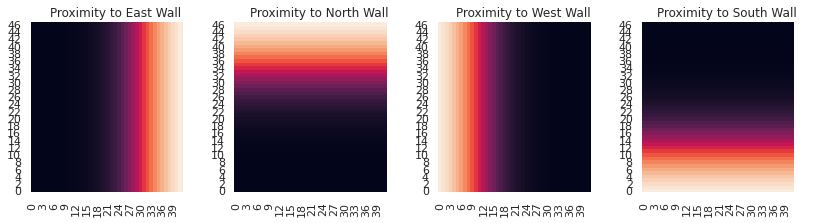

In [51]:
f,ax=plt.subplots(1,4, figsize=(14,6))
sns.heatmap(east_prox,ax=ax[0],cbar=False)
ax[0].invert_yaxis()
ax[0].axis('square')
ax[0].set_title('Proximity to East Wall')

sns.heatmap(north_prox,ax=ax[1],cbar=False)
ax[1].invert_yaxis()
ax[1].axis('square')
ax[1].set_title('Proximity to North Wall')

sns.heatmap(west_prox,ax=ax[2],cbar=False)
ax[2].invert_yaxis()
ax[2].axis('square')
ax[2].set_title('Proximity to West Wall')

sns.heatmap(south_prox,ax=ax[3],cbar=False)
ax[3].invert_yaxis()
ax[3].axis('square')
ax[3].set_title('Proximity to South Wall')

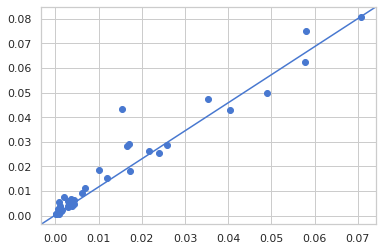

In [48]:
#plt.scatter(nrmse_sm,nrmse_sm2)
plt.scatter(ar2_sm,ar2_sm2)

plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)

### linear

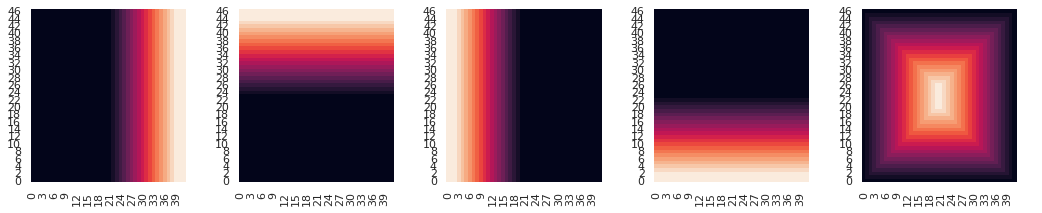

In [80]:
height, width = fr_maps.shape[1:]
spatial_funcs = reload(spatial_funcs)

def get_lin_proximity_array(dim_size, border_width):
    dim_size2 = dim_size//2
    
    out_array = np.zeros(dim_size)
    out_array[dim_size-border_width:] = 1
    
    n_lin_bins = dim_size2-border_width + np.mod(dim_size,2)
    out_array[dim_size2:(dim_size-border_width)] = np.arange(n_lin_bins)/n_lin_bins 

    return out_array

#east_prox = np.tile(np.arange(width), height).reshape(height, width)
east_prox = np.tile(get_lin_proximity_array(width,wall_width), height).reshape(height, width)
west_prox = np.fliplr(east_prox)

north_prox = np.repeat(get_lin_proximity_array(height,wall_width), width).reshape(height, width)
south_prox = np.flipud(north_prox)

center_prox = spatial_funcs.get_center_border_distance_mat(height, width)

prox_mats = np.zeros((5, height, width))
prox_mats[0] = east_prox
prox_mats[1] = north_prox
prox_mats[2] = west_prox
prox_mats[3] = south_prox
prox_mats[4] = center_prox

f,ax=plt.subplots(1,5, figsize=(18,6))

for ii,p in enumerate(prox_mats):
    sns.heatmap(prox_mats[ii],ax=ax[ii],cbar=False)
    ax[ii].invert_yaxis()
    ax[ii].axis('square')


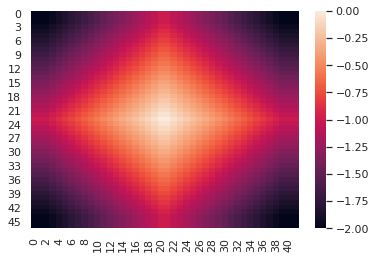

In [83]:
sns.heatmap(-1*prox_mats[:4,:,:].sum(axis=0))

### test implementation

In [87]:
spatial_funcs = reload(spatial_funcs)
rs = reload(rs)

a,b,c = spatial_funcs.get_border_encoding_model(of_dat.x, of_dat.y, fr, fr_maps, x_bin_edges=track_params.x_bin_edges_, y_bin_edges=track_params.y_bin_edges_, sig_alpha=track_params.sig_alpha, n_perm=track_params.n_perm, border_fr_thr=track_params.border_fr_thr, min_field_size_bins=track_params.border_min_field_size_bins, border_width_bins=track_params.border_width_bins, feat_type='sig')

In [93]:
a

,solstad_score,solstad_sig,aR2,rmse,nrmse
0,0.404270,1.0,0.003700,5.030760,2.199718
1,0.434732,1.0,0.017117,11.582826,0.936915
2,0.433749,1.0,0.025105,10.779935,1.034139
3,0.418933,1.0,0.044362,6.574677,1.063815
4,0.425475,1.0,0.021492,24.517384,0.747700
5,0.460603,0.0,0.027956,6.941431,1.818598
6,0.493673,0.0,0.013752,6.820802,1.944974
7,0.401554,1.0,0.001446,4.930913,2.207151
8,0.479082,0.0,0.003876,8.020961,1.725945
9,0.424514,1.0,0.005720,8.474876,1.256607


In [95]:
import statsmodels.api as sm
b2 = np.array(b)
b2[:,1:] = np.abs(b2[:,1:])
m=sm.OLS(a['solstad_score'],b2).fit()
print(m.summary2())

                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.324  
Dependent Variable:     solstad_score    AIC:                         27.9750
Date:                   2020-10-05 20:29 BIC:                         37.6405
No. Observations:       37               Log-Likelihood:              -7.9875
Df Model:               6                F-statistic:                 3.959  
Df Residuals:           31               Prob (F-statistic):          0.00471
R-squared (uncentered): 0.434            Scale:                       0.10762
----------------------------------------------------------------------------------
            Coef.       Std.Err.         t         P>|t|        [0.025      0.975]
----------------------------------------------------------------------------------
x1          0.0157        0.0171       0.9145      0.3675      -0.0193      0.0506
x2          0.0064        0.0585       0.1094      0.9136      -0.1

on this data set, the encoding model coefficients can be used to explained 31% of the border score variance. interestingly, the largest predictor of border score were the mean firing rate coefficient and the center proximity coefficient.

In [109]:
a,b,c = spatial_funcs.get_border_encoding_model(of_dat.x, of_dat.y, fr, fr_maps, x_bin_edges=track_params.x_bin_edges_, y_bin_edges=track_params.y_bin_edges_, sig_alpha=track_params.sig_alpha, n_perm=track_params.n_perm, border_fr_thr=track_params.border_fr_thr, min_field_size_bins=track_params.border_min_field_size_bins, border_width_bins=track_params.border_width_bins, feat_type='lin')

In [97]:
b2 = np.array(b)
b2[:,1:] = np.abs(b2[:,1:])
m=sm.OLS(a['solstad_score'],b2).fit()
print(m.summary2())

                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.367  
Dependent Variable:     solstad_score    AIC:                         25.5601
Date:                   2020-10-05 20:31 BIC:                         35.2256
No. Observations:       37               Log-Likelihood:              -6.7801
Df Model:               6                F-statistic:                 4.575  
Df Residuals:           31               Prob (F-statistic):          0.00196
R-squared (uncentered): 0.470            Scale:                       0.10082
----------------------------------------------------------------------------------
            Coef.       Std.Err.         t         P>|t|        [0.025      0.975]
----------------------------------------------------------------------------------
x1          0.0235        0.0158       1.4909      0.1461      -0.0086      0.0556
x2          0.0215        0.0438       0.4921      0.6261      -0.0

0.0047415836889521095


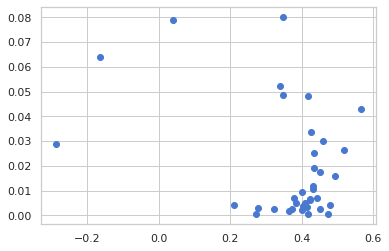

In [101]:
print(rs.spearman(a['solstad_score'],a['aR2']))
plt.scatter(a['solstad_score'],a['aR2'])

In [113]:
spatial_funcs = reload(spatial_funcs)
a,b,c = spatial_funcs.get_border_encoding_model(of_dat.x, of_dat.y, fr, fr_maps, x_bin_edges=track_params.x_bin_edges_, y_bin_edges=track_params.y_bin_edges_, sig_alpha=track_params.sig_alpha, n_perm=track_params.n_perm, border_fr_thr=track_params.border_fr_thr, min_field_size_bins=track_params.border_min_field_size_bins, border_width_bins=track_params.border_width_bins, feat_type='lin')

In [114]:
a

,solstad_score,solstad_sig,aR2,rmse,nrmse
0,0.404270,0.0,0.003700,5.030760,2.199718
1,0.434732,0.0,0.017117,11.582826,0.936915
2,0.433749,0.0,0.025105,10.779935,1.034139
3,0.418933,0.0,0.044362,6.574677,1.063815
4,0.425475,0.0,0.021492,24.517384,0.747700
5,0.460603,0.0,0.027956,6.941431,1.818598
6,0.493673,1.0,0.013752,6.820802,1.944974
7,0.401554,0.0,0.001446,4.930913,2.207151
8,0.479082,1.0,0.003876,8.020961,1.725945
9,0.424514,0.0,0.005720,8.474876,1.256607


### figures for illustrating methodology

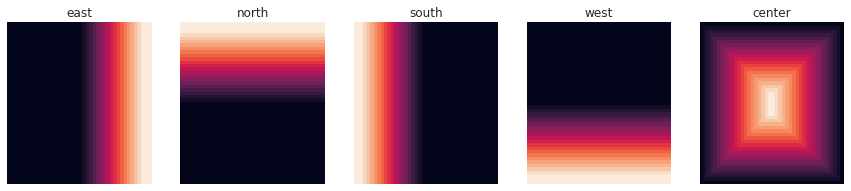

In [13]:
mats = spatial_funcs.get_linear_border_proximity_mats(42,47,3)
f,ax = plt.subplots(1,5,figsize=(15,5))
walls = ['east', 'north', 'south', 'west','center']
for ii, ax_i in enumerate(ax):
    sns.heatmap(mats[ii],xticklabels=False, yticklabels=False, ax=ax_i, cbar=False, square=True)
    ax_i.invert_yaxis()
    ax_i.set_title(walls[ii])

fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/'linear_border_prox_mats', bbox_inches='tight')

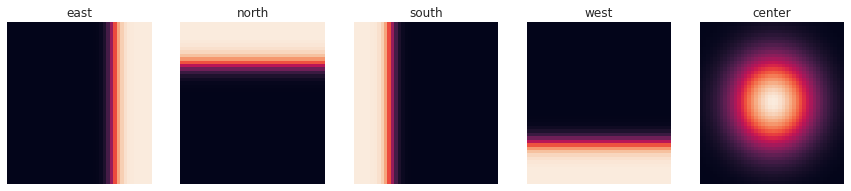

In [14]:
mats = spatial_funcs.get_sigmoid_border_proximity_mats(42,47,3)
f,ax = plt.subplots(1,5,figsize=(15,5))
walls = ['east', 'north', 'south', 'west','center']
for ii, ax_i in enumerate(ax):
    sns.heatmap(mats[ii],xticklabels=False, yticklabels=False, ax=ax_i, cbar=False, square=True)
    ax_i.invert_yaxis()
    ax_i.set_title(walls[ii])

fig_path = Path('/home/alexgonzalez/Documents/treemazefigs/misc_figs/')
f.savefig(fig_path/'sigmoid_border_prox_mats', bbox_inches='tight')